In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("data.csv")
df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})

X = df.drop(columns=["id", "diagnosis"])
y = df["diagnosis"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [3]:
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)


c:\Users\savan\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('lr', LogisticRegression(max_iter=1000))])

In [4]:
#threshhold 0.5
print("--- 📊 Standard Prediction (Threshold 0.5) ---")
y_pred_default = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred_default))
print(classification_report(y_test, y_pred_default))
#treshhold 0.3
print("\n" + "="*50 + "\n")
print("--- 🚨 Adjusted Prediction (Threshold 0.3) ---")
y_probs = pipeline.predict_proba(X_test)[:, 1]
custom_threshold = 0.3
y_pred_custom = (y_probs >= custom_threshold).astype(int)

print(f"Confusion Matrix (Threshold: {custom_threshold}):")
print(confusion_matrix(y_test, y_pred_custom))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_custom))

--- 📊 Standard Prediction (Threshold 0.5) ---
[[71  1]
 [ 3 39]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



--- 🚨 Adjusted Prediction (Threshold 0.3) ---
Confusion Matrix (Threshold: 0.3):
[[71  1]
 [ 1 41]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.98      0.98      0.98        42

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



c:\Users\savan\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\Users\savan\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [5]:
lr_model = pipeline.named_steps["lr"]
weights = lr_model.coef_[0]
bias = lr_model.intercept_[0]
print(f"Model Intercept (Bias): {bias}\n")


Model Intercept (Bias): -0.2430053269056029



In [6]:
feature_names = pipeline[:-1].get_feature_names_out()
feature_weights = pd.DataFrame({
    'Feature': feature_names,
    'Weight': weights
})

feature_weights['Absolute_Weight'] = feature_weights['Weight'].abs()
feature_weights = feature_weights.sort_values(by='Absolute_Weight', ascending=False)
feature_weights = feature_weights.drop(columns=['Absolute_Weight'])

print("Feature Weights (Sorted by Importance):")
print(feature_weights.to_string(index=False))

Feature Weights (Sorted by Importance):
                Feature    Weight
          texture_worst  1.434093
              radius_se  1.233325
         symmetry_worst  1.061264
    concave points_mean  0.952813
        concavity_worst  0.911406
                area_se  0.909029
         compactness_se -0.906925
             area_worst  0.900477
           radius_worst  0.896968
         concavity_mean  0.782298
           perimeter_se  0.748295
        perimeter_worst  0.723111
   concave points_worst  0.703999
   fractal_dimension_se -0.593876
           texture_mean  0.482219
      concave points_se  0.482089
              area_mean  0.439950
       compactness_mean -0.439546
       smoothness_worst  0.420207
             texture_se -0.407611
            radius_mean  0.361150
         perimeter_mean  0.353160
        smoothness_mean  0.350622
            symmetry_se -0.330658
          smoothness_se  0.247991
      compactness_worst -0.173488
          symmetry_mean -0.163991
        

In [7]:

false_negative_mask = (y_test == 1) & (y_pred_custom == 0)
missed_patient = X_test[false_negative_mask].copy()
missed_patient['Model_Probability'] = y_probs[false_negative_mask]
print("🚨 Detailed Profile of the Missed Patient(s) 🚨\n")
print(missed_patient.T)

🚨 Detailed Profile of the Missed Patient(s) 🚨

                                 73
radius_mean               13.800000
texture_mean              15.790000
perimeter_mean            90.430000
area_mean                584.100000
smoothness_mean            0.100700
compactness_mean           0.128000
concavity_mean             0.077890
concave points_mean        0.050690
symmetry_mean              0.166200
fractal_dimension_mean     0.065660
radius_se                  0.278700
texture_se                 0.620500
perimeter_se               1.957000
area_se                   23.350000
smoothness_se              0.004717
compactness_se             0.020650
concavity_se               0.017590
concave points_se          0.009206
symmetry_se                0.012200
fractal_dimension_se       0.003130
radius_worst              16.570000
texture_worst             20.860000
perimeter_worst          110.300000
area_worst               812.400000
smoothness_worst           0.141100
compactness_worst

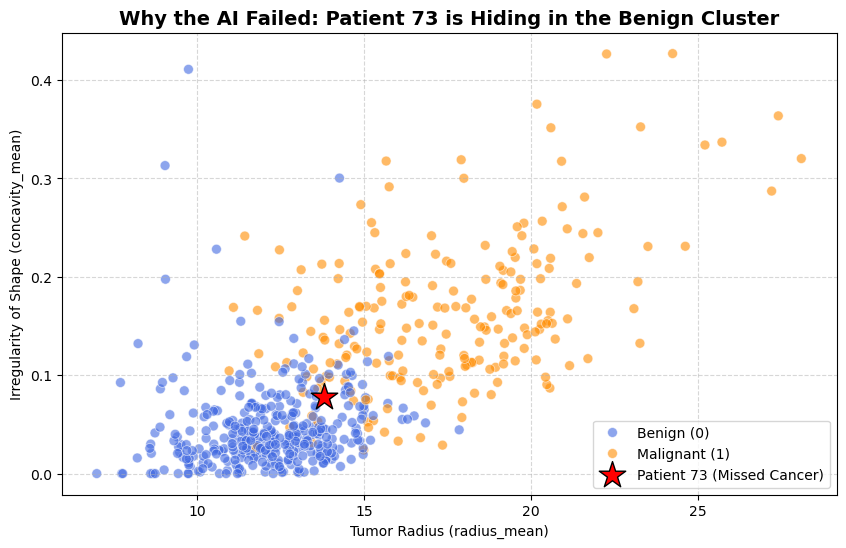

In [8]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df, 
    x='radius_mean', 
    y='concavity_mean', 
    hue='diagnosis', 
    palette={0: 'royalblue', 1: 'darkorange'},
    alpha=0.6,
    s=50
)

patient_radius = 13.800000
patient_concavity = 0.077890

plt.scatter(
    x=patient_radius, 
    y=patient_concavity, 
    color='red', 
    s=400,          
    marker='*',     
    edgecolor='black', 
    label='Patient 73 (Missed Cancer)'
)

plt.title('Why the AI Failed: Patient 73 is Hiding in the Benign Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Tumor Radius (radius_mean)')
plt.ylabel('Irregularity of Shape (concavity_mean)')
handles, labels = plt.gca().get_legend_handles_labels()

new_labels = ['Benign (0)' if l == '0' else 'Malignant (1)' if l == '1' else l for l in labels]
plt.legend(handles, new_labels)

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



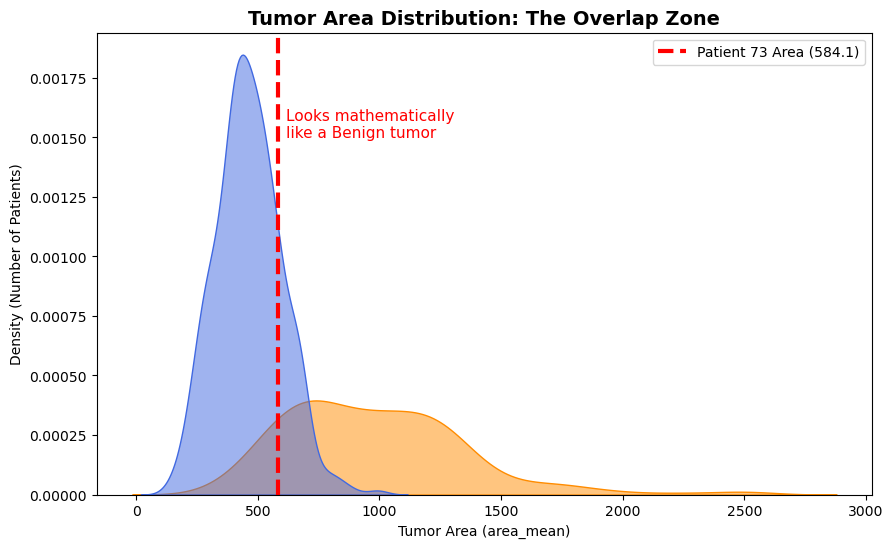

In [9]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df, 
    x='area_mean', 
    hue='diagnosis', 
    fill=True, 
    palette={0: 'royalblue', 1: 'darkorange'}, 
    alpha=0.5
)
patient_area = 584.100000

plt.axvline(
    x=patient_area, 
    color='red', 
    linestyle='--', 
    linewidth=3, 
    label=f'Patient 73 Area ({patient_area})'
)
plt.title('Tumor Area Distribution: The Overlap Zone', fontsize=14, fontweight='bold')
plt.xlabel('Tumor Area (area_mean)')
plt.ylabel('Density (Number of Patients)')

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['Benign (0)' if l == '0' else 'Malignant (1)' if l == '1' else l for l in labels]
plt.legend(handles, new_labels)
plt.text(patient_area + 30, 0.0015, 'Looks mathematically\nlike a Benign tumor', color='red', fontsize=11)

plt.show()


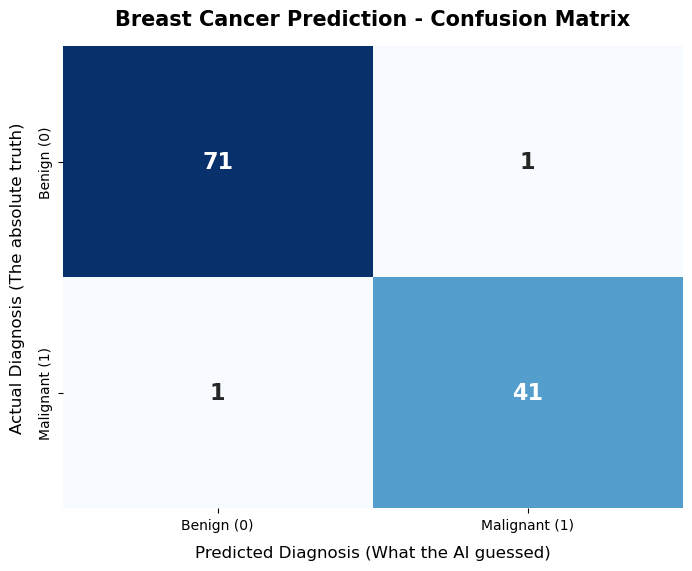

In [10]:

cm = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='g', 
    cmap='Blues', 
    cbar=False,   
    annot_kws={"size": 16, "weight": "bold"}, 
    xticklabels=['Benign (0)', 'Malignant (1)'], 
    yticklabels=['Benign (0)', 'Malignant (1)']
)

plt.title('Breast Cancer Prediction - Confusion Matrix', fontsize=15, fontweight='bold', pad=15)
plt.xlabel('Predicted Diagnosis (What the AI guessed)', fontsize=12, labelpad=10)
plt.ylabel('Actual Diagnosis (The absolute truth)', fontsize=12, labelpad=10)

plt.show()
